<a href="https://colab.research.google.com/github/HARSHIT097/Keras01-RNN_Stock_price/blob/main/Stock_returns_tf_rnn_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
#vggpre processing and reddits ranking algorithm

df = pd.read_csv("/content/MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8852,2021-04-27,261.579987,263.190002,260.119995,261.970001,261.970001,31014200
8853,2021-04-28,256.079987,256.540009,252.949997,254.559998,254.559998,46903100
8854,2021-04-29,255.460007,256.100006,249.000000,252.509995,252.509995,40589000
8855,2021-04-30,249.740005,253.080002,249.600006,252.179993,252.179993,30929200
8856,2021-05-03,253.399994,254.350006,251.119995,251.860001,251.860001,19598900


In [ ]:
#start whetehr doing right/wrong thing - trying to predict the price itself

series = df['Close'].values.reshape(-1,1)

In [ ]:
#Normalize the data
#Note: by approximation we assuming the boundary
scaler =StandardScaler()
scaler.fit(series[:len(series)//2]) #taking first half data
series = scaler.transform(series).flatten()

In [ ]:
#building the dataset
#let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)
print("X.shape and Y.shape", X.shape, Y.shape)

X.shape and Y.shape (8847, 10, 1) (8847,)


In [ ]:
#auto regressive RNN model

i = Input(shape=(T,1))
#x = SimpleRNN(5, activation='relu')(i)
#x = SimpleRNN(5)(i) #deault activation function is tanh
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer = Adam(lr=0.001),
) 

#train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=100,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/100
139/139 [==============================] - 3s 9ms/step - loss: 0.9732 - val_loss: 18.1256
Epoch 2/100
139/139 [==============================] - 1s 6ms/step - loss: 0.2883 - val_loss: 15.6961
Epoch 3/100
139/139 [==============================] - 1s 6ms/step - loss: 0.1139 - val_loss: 14.7388
Epoch 4/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0649 - val_loss: 13.8066
Epoch 5/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0318 - val_loss: 13.0622
Epoch 6/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0181 - val_loss: 12.6581
Epoch 7/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 12.3552
Epoch 8/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0065 - val_loss: 12.1144
Epoch 9/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 11.9100
Epoch 10/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0050

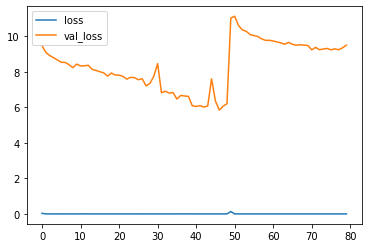

In [ ]:
#plot loss per iteration
plt.plot(r.history["loss"], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

shape of output (8847, 1)


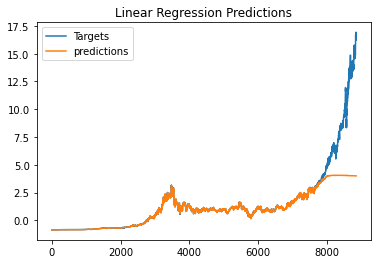

In [ ]:
#one-step forecast using true targets
#note: even the one-step forecast fails badly

outputs = model.predict(X)
print("shape of output", outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label="Targets")
plt.plot(predictions, label="predictions")
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

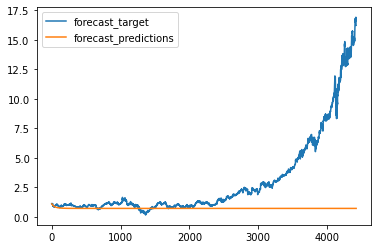

In [ ]:
#multi step forecast using true targets
validation_target = Y[-N//2:]
validation_prediction = []

#index of last train input
last_x = X[-N//2] #1-D array of length T
while len(validation_prediction) < len(validation_target):
  p = model.predict(last_x.reshape(1,T,1))[0,0] #1 x 1 array -> scalar
  
  #updating prediction list
  validation_prediction.append(p)
  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p
  
plt.plot(validation_target, label='forecast_target')
plt.plot(validation_prediction, label='forecast_predictions')
plt.legend()

In [ ]:
#calculate returns by first shifting the data

df['PrevClose'] = df['Close'].shift(1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000,0.097222
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200,0.100694
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400,0.102431
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400,0.099826


In [ ]:
df['Return'] = (df['Close'] - df['PrevClose']) /df['PrevClose']
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose,Return
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800,NaN,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000,0.097222,0.035712
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200,0.100694,0.017250
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400,0.102431,-0.025432
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400,0.099826,-0.017390


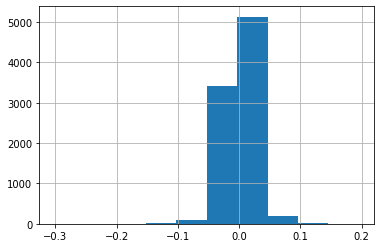

In [ ]:
df['Return'].hist()

In [ ]:
#building Lstm
series = df['Close'].values.reshape(-1,1)
#Normalize the data
#Note: by approximation we assuming the boundary
scaler =StandardScaler()
scaler.fit(series[:len(series)//2]) #taking first half data
series = scaler.transform(series).flatten()

In [ ]:
#building the dataset
#let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)
print("X.shape and Y.shape", X.shape, Y.shape)

X.shape and Y.shape (8847, 10, 1) (8847,)


In [ ]:
#auto regressive RNN model

i = Input(shape=(T,1))
#x = SimpleRNN(5, activation='relu')(i)
#x = SimpleRNN(5)(i) #deault activation function is tanh
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer = Adam(lr=0.001),
) 

#train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=100,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/100
139/139 [==============================] - 3s 9ms/step - loss: 1.0439 - val_loss: 20.8864
Epoch 2/100
139/139 [==============================] - 1s 6ms/step - loss: 0.3119 - val_loss: 18.3249
Epoch 3/100
139/139 [==============================] - 1s 6ms/step - loss: 0.1196 - val_loss: 16.3264
Epoch 4/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0862 - val_loss: 14.9362
Epoch 5/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0489 - val_loss: 13.8837
Epoch 6/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0323 - val_loss: 13.1319
Epoch 7/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0196 - val_loss: 12.5572
Epoch 8/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0109 - val_loss: 12.1099
Epoch 9/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0077 - val_loss: 11.7449
Epoch 10/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0054

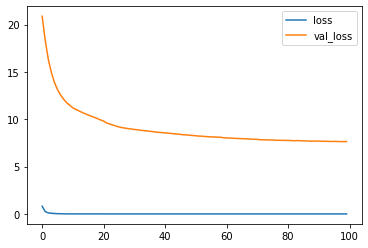

In [ ]:
#plot loss per iteration
plt.plot(r.history["loss"], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

shape of output (8847, 1)


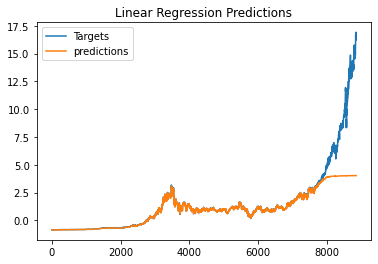

In [ ]:
#one-step forecast using true targets
#note: even the one-step forecast fails badly

outputs = model.predict(X)
print("shape of output", outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label="Targets")
plt.plot(predictions, label="predictions")
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

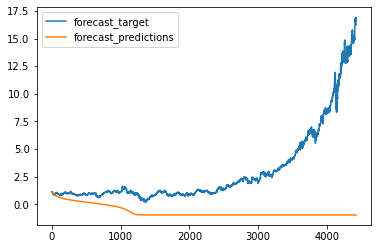

In [ ]:
#multi step forecast using true targets
validation_target = Y[-N//2:]
validation_prediction = []

#index of last train input
last_x = X[-N//2] #1-D array of length T
while len(validation_prediction) < len(validation_target):
  p = model.predict(last_x.reshape(1,T,1))[0,0] #1 x 1 array -> scalar
  
  #updating prediction list
  validation_prediction.append(p)
  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p
  
plt.plot(validation_target, label='forecast_target')
plt.plot(validation_prediction, label='forecast_predictions')
plt.legend()

#model with all features

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'PrevClose', 'Return'],
      dtype='object')

In [ ]:
input_data = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
targets = df['Return'].values

In [ ]:
#making actual data for neural network
T =10
D = input_data.shape[1]
N = len(input_data) - T

In [ ]:
#normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)


In [ ]:
#setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [ ]:
#setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_train[u] = (targets[t+T] > 0)

In [ ]:
#make RNN


i = Input(shape=(T,D))
#x = SimpleRNN(5, activation='relu')(i)
#x = SimpleRNN(5)(i) #deault activation function is tanh
x = GRU(50)(i) #LSTM
x = Dense(1, activation='sigmoid')(x)
model = Model(i,x)
model.compile(
    loss='binary_crossentropy',
    optimizer = Adam(lr=0.001),
    metrics=['accuracy'],
) 

#train RNN
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
185/185 [==============================] - 4s 9ms/step - loss: 0.6939 - accuracy: 0.5194 - val_loss: 0.6221 - val_accuracy: 0.6619
Epoch 2/300
185/185 [==============================] - 1s 7ms/step - loss: 0.6927 - accuracy: 0.5216 - val_loss: 0.4809 - val_accuracy: 0.9993
Epoch 3/300
185/185 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5231 - val_loss: 0.5899 - val_accuracy: 0.8879
Epoch 4/300
185/185 [==============================] - 1s 7ms/step - loss: 0.6921 - accuracy: 0.5280 - val_loss: 0.7076 - val_accuracy: 0.4125
Epoch 5/300
185/185 [==============================] - 1s 7ms/step - loss: 0.6922 - accuracy: 0.5188 - val_loss: 0.5714 - val_accuracy: 0.9837
Epoch 6/300
185/185 [==============================] - 1s 7ms/step - loss: 0.6939 - accuracy: 0.5008 - val_loss: 0.6422 - val_accuracy: 0.7598
Epoch 7/300
185/185 [==============================] - 1s 7ms/step - loss: 0.6931 - accuracy: 0.5124 - val_loss: 0.6641 - val_accuracy: 0.6201

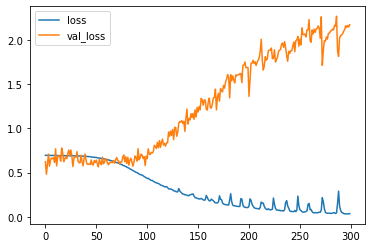

In [ ]:
#plot loss per iteration
plt.plot(r.history["loss"], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

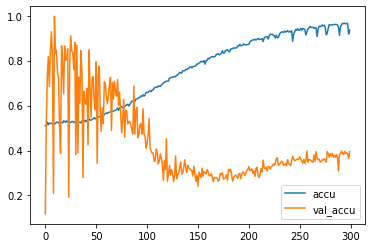

In [ ]:
#plot loss per iteration
plt.plot(r.history["accuracy"], label='accu')
plt.plot(r.history['val_accuracy'], label = 'val_accu')
plt.legend()
plt.show()

# nifty data